In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from monai.transforms import LoadImaged, Compose, Resized, EnsureChannelFirstd

# Add the project source to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import your custom transform
from src.data.transforms import RidgeletTransformd

# Set notebook style
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete.")

Setup complete.


In [2]:
# Load environment variables
load_dotenv(dotenv_path='../.env')
IMAGE_ROOT_DIR = os.getenv("MIMIC_CXR_P_FOLDERS_PATH")
PROJECT_DATA_FOLDER_PATH = os.getenv("PROJECT_DATA_FOLDER_PATH")

if not all([IMAGE_ROOT_DIR, PROJECT_DATA_FOLDER_PATH]):
    raise ValueError("Please ensure all required environment variables are set.")

# --- 1. Load data and select a sample with a fracture ---
val_csv_path = os.path.join(PROJECT_DATA_FOLDER_PATH, "splits", "split_2000", "validation.csv")
df_val = pd.read_csv(val_csv_path)

df_fractures = df_val[df_val['fracture'] == 1]
if df_fractures.empty:
    raise ValueError("No fracture cases found in the validation split.")

# Get image path
sample_record = df_fractures.iloc[0]
subject_id = str(int(sample_record['subject_id']))
study_id = str(int(sample_record['study_id']))
dicom_id = str(sample_record['dicom_id'])
image_relative_path = os.path.join(f"p{subject_id[:2]}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")
full_image_path = os.path.join(IMAGE_ROOT_DIR, image_relative_path)

sample_dict = {"image": full_image_path}
print(f"Successfully located image with a fracture:\n{full_image_path}")

Successfully located image with a fracture:
E:/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/files\p19\p19175595\s52445151\468a1675-344a56da-7cf12651-0344086a-8454a87a.jpg


In [3]:
# --- Configuration for Visualization ---
SQUARE_SIZE = 512
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running transforms on device: {DEVICE}")

# --- Base Preprocessing ---
base_pipeline = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Resized(keys=["image"], spatial_size=(SQUARE_SIZE, SQUARE_SIZE)),
])
preprocessed_dict = base_pipeline(sample_dict)
original_image_tensor = preprocessed_dict['image']

# --- Define and Apply Ridgelet Transform Configurations ---

# Config 1: No Thresholding (keep 100% of coefficients)
print("Applying Ridgelet Transform with NO thresholding (sparsity_level=1.0)...")
ridgelet_transformer_1 = RidgeletTransformd(keys=["image"], sparsity_level=1.0, device=DEVICE)
result_1 = ridgelet_transformer_1(preprocessed_dict.copy())

# Config 2: Keep top 10% of coefficients
print("Applying Ridgelet Transform with 10% sparsity...")
ridgelet_transformer_2 = RidgeletTransformd(keys=["image"], sparsity_level=0.99, device=DEVICE)
result_2 = ridgelet_transformer_2(preprocessed_dict.copy())

# Config 3: Keep top 5% of coefficients
print("Applying Ridgelet Transform with 5% sparsity...")
ridgelet_transformer_3 = RidgeletTransformd(keys=["image"], sparsity_level=0.05, device=DEVICE)
result_3 = ridgelet_transformer_3(preprocessed_dict.copy())

# Config 4: Keep top 1% of coefficients (very sparse)
print("Applying Ridgelet Transform with 1% sparsity...")
ridgelet_transformer_4 = RidgeletTransformd(keys=["image"], sparsity_level=0.01, device=DEVICE)
result_4 = ridgelet_transformer_4(preprocessed_dict.copy())

print("\nAll Ridgelet transform configurations applied successfully.")

Running transforms on device: cuda
Applying Ridgelet Transform with NO thresholding (sparsity_level=1.0)...
Applying Ridgelet Transform with 10% sparsity...
Applying Ridgelet Transform with 5% sparsity...
Applying Ridgelet Transform with 1% sparsity...

All Ridgelet transform configurations applied successfully.


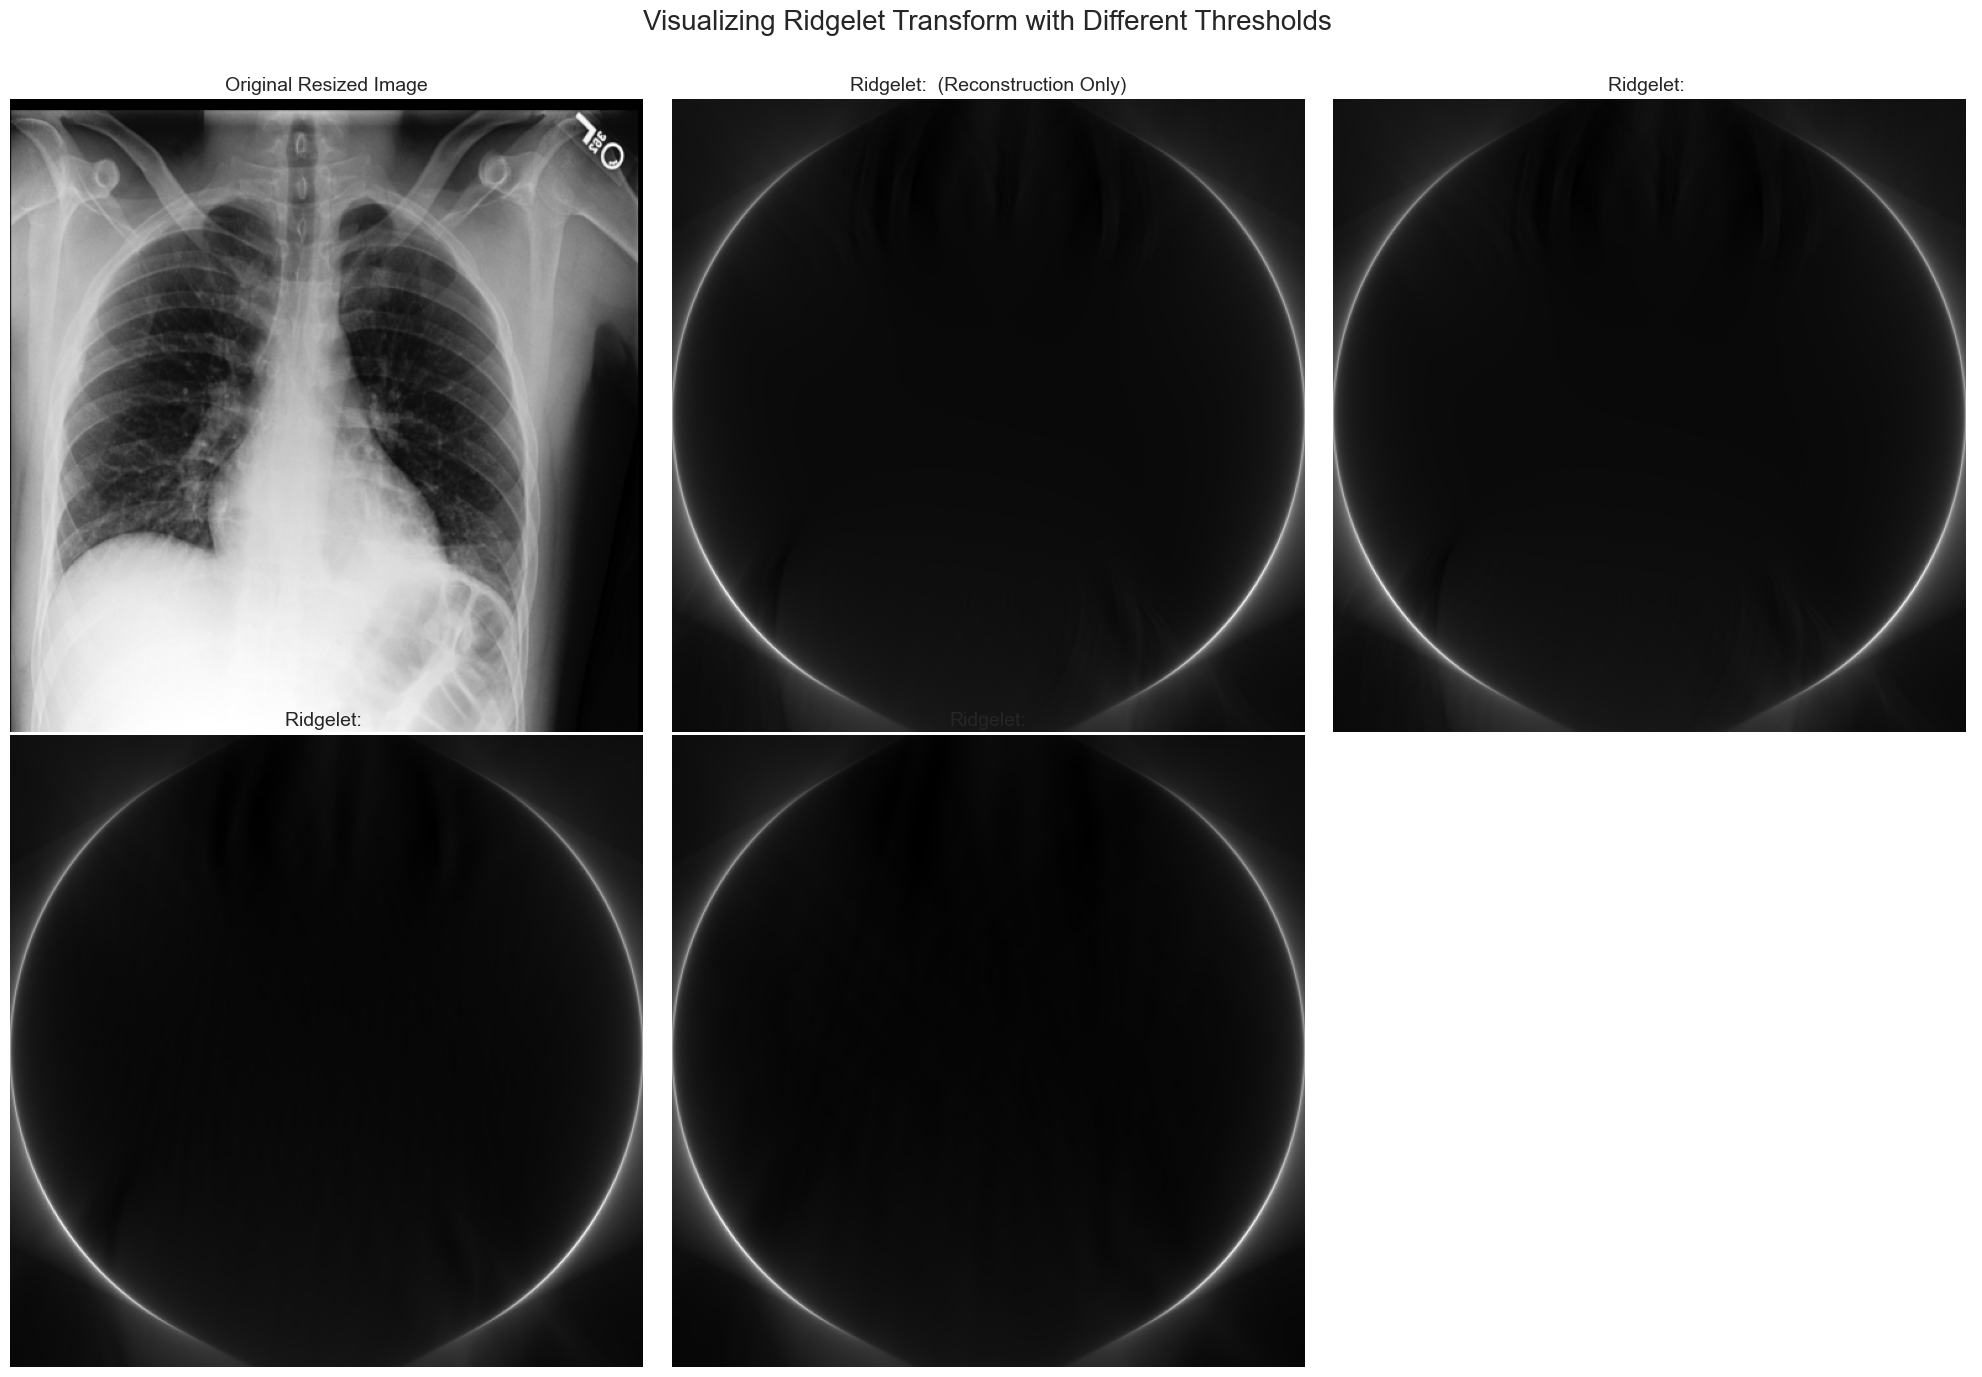

In [4]:
# --- Prepare Tensors for Plotting ---
# For GPU tensors, you must move them to the CPU before calling .numpy()
original_np = original_image_tensor.squeeze().cpu().numpy()
ridgelet_1_np = result_1['image'].squeeze().cpu().numpy()
ridgelet_2_np = result_2['image'].squeeze().cpu().numpy()
ridgelet_3_np = result_3['image'].squeeze().cpu().numpy()
ridgelet_4_np = result_4['image'].squeeze().cpu().numpy()

# --- Create a figure to display all results ---
# Note: A 2x2 grid is better for 4 results + original. Let's use a 2x3 grid to show all 4 transforms.
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle("Visualizing Ridgelet Transform with Different Thresholds", fontsize=20)

axes[0, 0].imshow(original_np.T, cmap='gray')
axes[0, 0].set_title('Original Resized Image', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(ridgelet_1_np.T, cmap='gray')
axes[0, 1].set_title(f"Ridgelet:  (Reconstruction Only)", fontsize=14)
axes[0, 1].axis('off')

axes[0, 2].imshow(ridgelet_2_np.T, cmap='gray')
axes[0, 2].set_title(f"Ridgelet: ", fontsize=14)
axes[0, 2].axis('off')

axes[1, 0].imshow(ridgelet_3_np.T, cmap='gray')
axes[1, 0].set_title(f"Ridgelet: ", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(ridgelet_4_np.T, cmap='gray')
axes[1, 1].set_title(f"Ridgelet:", fontsize=14)
axes[1, 1].axis('off')

# Hide the unused subplot
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

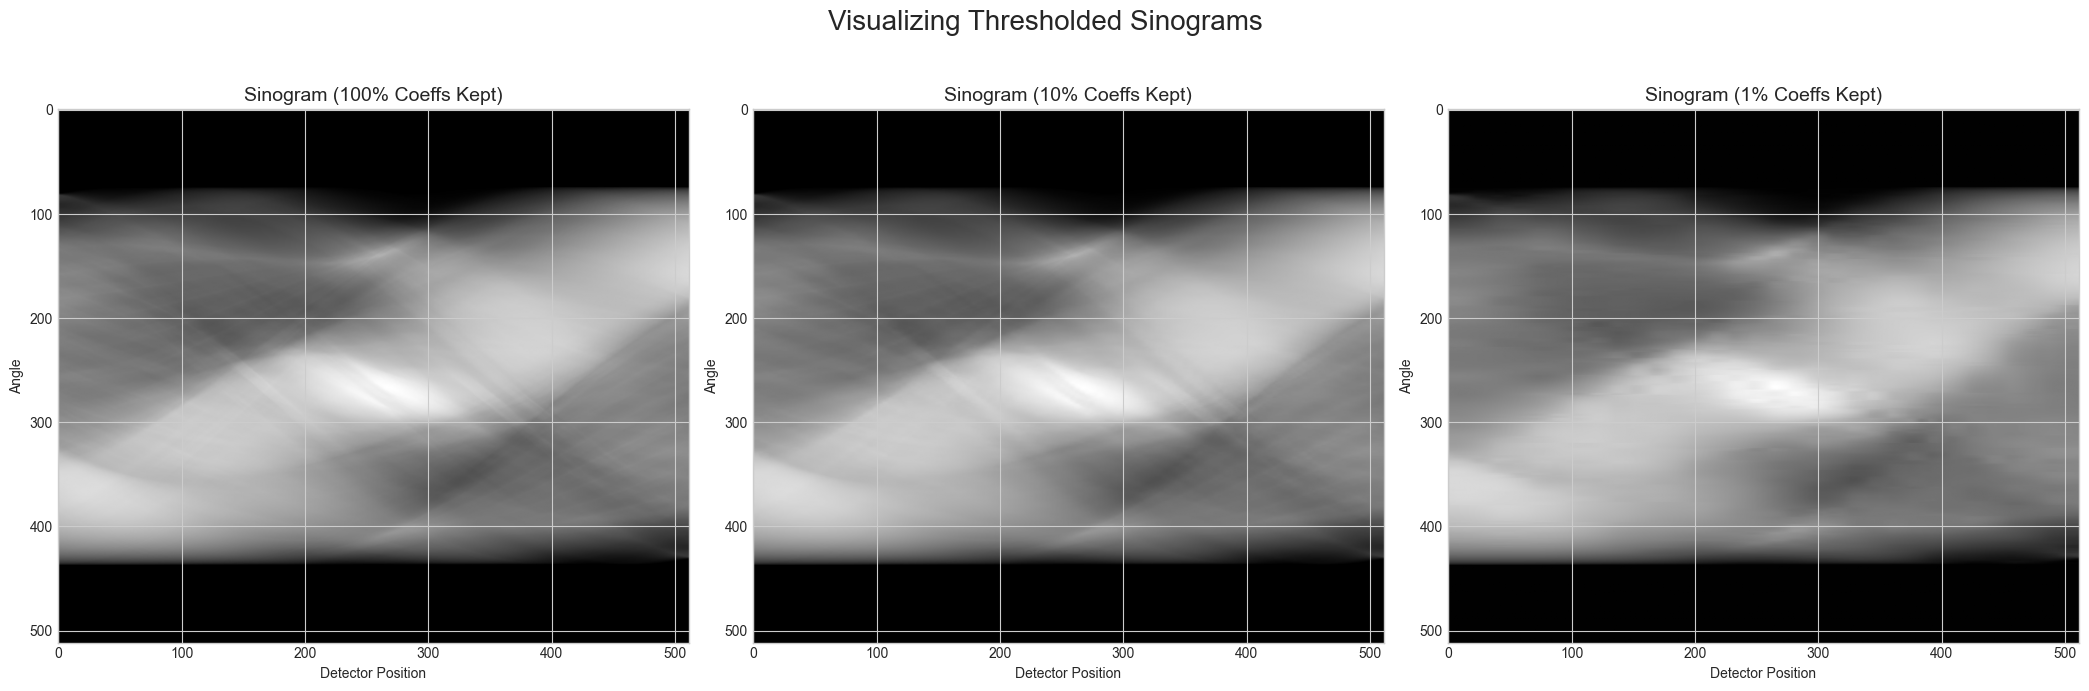

In [5]:
# --- Visualize the Thresholded Sinograms ---
# This allows us to see the direct output of the feature extraction
# before the inverse radon transform introduces artifacts.

# --- Define Transformers for Sinogram Output ---

# Config 1: Sinogram with NO Thresholding (sparsity_level=1.0)
sino_transformer_1 = RidgeletTransformd(
    keys=["image"],
    sparsity_level=1.0,
    output_type='sinogram',  # <-- Get the sinogram
    device=DEVICE
)
sino_result_1 = sino_transformer_1(preprocessed_dict.copy())

# Config 2: Sinogram with 10% Sparsity
sino_transformer_2 = RidgeletTransformd(
    keys=["image"],
    sparsity_level=0.1,      # Keep top 10%
    output_type='sinogram',  # <-- Get the sinogram
    device=DEVICE
)
sino_result_2 = sino_transformer_2(preprocessed_dict.copy())


# Config 3: Sinogram with 1% Sparsity (very sparse)
sino_transformer_3 = RidgeletTransformd(
    keys=["image"],
    sparsity_level=0.01,     # Keep top 1%
    output_type='sinogram',  # <-- Get the sinogram
    device=DEVICE
)
sino_result_3 = sino_transformer_3(preprocessed_dict.copy())


# --- Prepare Tensors for Plotting ---
sino_1_np = sino_result_1['image'].squeeze().cpu().numpy()
sino_2_np = sino_result_2['image'].squeeze().cpu().numpy()
sino_3_np = sino_result_3['image'].squeeze().cpu().numpy()


# --- Create a figure to display all sinogram results ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle("Visualizing Thresholded Sinograms", fontsize=20)

# Plot Sinogram at 100%
axes[0].imshow(sino_1_np, cmap='gray', aspect='auto')
axes[0].set_title('Sinogram (100% Coeffs Kept)', fontsize=14)
axes[0].set_xlabel('Detector Position')
axes[0].set_ylabel('Angle')

# Plot Sinogram at 10%
axes[1].imshow(sino_2_np, cmap='gray', aspect='auto')
axes[1].set_title('Sinogram (10% Coeffs Kept)', fontsize=14)
axes[1].set_xlabel('Detector Position')
axes[1].set_ylabel('Angle')

# Plot Sinogram at 1%
axes[2].imshow(sino_3_np, cmap='gray', aspect='auto')
axes[2].set_title('Sinogram (1% Coeffs Kept)', fontsize=14)
axes[2].set_xlabel('Detector Position')
axes[2].set_ylabel('Angle')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()